# Physics 5300 Double Pendulum 

<big><big>

Mark Fugate <br>
Prof. Furnstahl <br>
17 April 2019 <br>

</big>

We will implement the equations of motion for a double pendulum in a python class, allowing us to plot the motion and investigate its chaotic nature.


<br>

</big>

In [3]:
#start by importing all the packages we will need

%matplotlib notebook
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 10
plt.rcParams.update({'font.size': font_size})

<big>
Taylor tells us what the kinetic and potential energies for this system are (11.37 and 11.38): <br>
</big>
  
    

$T = \frac{1}{2}(m_1 + m_2) L_1^2 \dot{\phi}_1^2 + m_2 L_1 L_2 \dot{\phi_1} \dot{\phi_2}\cos(\phi_1 -\phi_2) + \frac{1}{2} m_2 L_2^2 \dot{\phi_2^2} $  
    
$U(\phi_1 , \phi_2) = (m_1 + m_2) g L_1 (1- \cos\phi_1) + m_2 g L_2 (1 - \cos\phi_2)$  

  


<big>

<big>
So, the lagrangian, T-U, is:
</big>

$\mathcal{L} = \frac{1}{2}(m_1 + m_2) L_1^2 \dot{\phi}_1^2 + m_2 L_1 L_2 \dot{\phi_1} \dot{\phi_2}\cos(\phi_1 -\phi_2) + \frac{1}{2} m_2 L_2^2 \dot{\phi_2^2} - (m_1 + m_2) g L_1 (1- \cos\phi_1) - m_2 g L_2 (1 - \cos\phi_2)  $
    
Our task is to solve Lagrange's equations to get expressions for $\ddot{\phi_1}$ and $\ddot{\phi_2}$ , because that's what we need for our differential equation solver.

Lagrange's equations are:

$\frac{\partial\mathcal{L}}{\partial\phi_1} = \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial\dot{\phi_1}}$
and
$\frac{\partial\mathcal{L}}{\partial\phi_2} = \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial\dot{\phi_2}}$

This leads us to the following mess:

$(m_1+m_2)L_1^2\ddot{\phi_1} + m_2 L_1 L_2 \cos(\phi_1 - \phi_2)\ddot{\phi_2} =  m_2 L_1 L_2 \dot{\phi_2} \sin(\phi_1 - \phi_2)(\dot{\phi_1} - \dot{\phi_2}) - m_2 L_1 L_2 \dot{\phi_1} \dot{\phi_2} \sin(\phi_1 - \phi_2) - (m_1 + m_2) g L_1 \sin\phi_1 $

and 

$m_2 L_2^2 \ddot{\phi_2} + m_2 L_1 L_2 \ddot{\phi_1} \cos(\phi_1 - \phi_2) = m_2 L_1 L_2 \dot{phi_1} \sin(\phi_1 - \phi_2) (\dot{\phi_1} - \dot{\phi_2}) + m_2 L_1 L_2 \dot{phi_1} \dot{\phi_2} \sin(\phi_1 - \phi_2 ) - m_2 g L_2 \sin \phi_2 $  


But we will not give up.

It's going to be much easier to express these with matrices.


</big>    
    


<big><big>

$\begin{equation}
\begin{bmatrix}(m_1 + m_2)L_1^2  &  m_2 L_1 L_2 \cos(\phi_1 - \phi_2)\\m_2 L_1 L_2 \cos(\phi_1 - \phi_2) & m_2 L_2^2\end{bmatrix} 
\begin{bmatrix}\ddot{\phi_1} \\ \ddot{\phi_2}\end{bmatrix}
 \end{equation} = 
\begin{bmatrix}
(-m_2L_1L_2)\dot{\phi_2^2}\sin(\phi_1-\phi_2)-(m_1+m_2)gL_1\sin\phi_1\\
m_2L_1L_2\dot{\phi_1^2}\sin(\phi_1-\phi_2)-m_2gL_2\sin\phi_2
\end{bmatrix}$


Let's make this a bit more compact:

<big>

$\begin{equation}
M \begin{bmatrix}\ddot{\phi_1} \\ \ddot{\phi_2}\end{bmatrix} 
\end{equation} = 
\begin{bmatrix}
R_0 \\
R_1
\end{bmatrix}
$

So, to get $\ddot{\phi_1}$ and $\ddot{\phi_2}$ we can multiply each side by the inverse of the $M$ matrix. Recall:
If,

$M = 
\begin{bmatrix} 
a & b \\
c & d
\end{bmatrix}$

Then,  

$M^{-1} = \frac{1}{det_M}  \begin{bmatrix}
d & -b\\
-c & a
\end{bmatrix}$

Where

$ det_M = ad-bc $

Finally, we can solve for $\ddot{\phi_1}$ and $\ddot{\phi_2}$

$\begin{equation}
\begin{bmatrix}\ddot{\phi_1} \\ \ddot{\phi_2}\end{bmatrix} 
\end{equation} = 
M^{-1}\begin{bmatrix}
R_0 \\
R_1
\end{bmatrix}
$

<big>

$\begin{equation}
\begin{bmatrix}\ddot{\phi_1} \\ \ddot{\phi_2}\end{bmatrix} 
\end{equation} = 
\frac{1}{det_M}  \begin{bmatrix}
d & -b\\
-c & a
\end{bmatrix}
\begin{bmatrix}
R_0 \\
R_1
\end{bmatrix}
$

So, in our class, we will define variables for a, b, c, d, det_m, R_0, and R_1, so that we can succinctly write $\ddot{\phi_1}$ and $\ddot{\phi_2}$ as

<br>

<big>

$\ddot{\phi_1} = \frac{d R_0 - b R_1}{det_M}$
<br> and <br>
$\ddot{\phi_2} = \frac{-c R_0 +a  R_1}{det_M} $

</big>

<big>
    Before we start, I'll remind you how our differential equation solver works. It's a function which, at a minimum, needs three arguments, like this:<br>
    <br> 
    odeint( function for our differential equation , initial conditions vector, time points array) <br> <br>
    So, we give it a set of initial conditions, and it considers how they are treated by a function we tell it to use, which should give us the derivative of the coordinates in the initial condtion vector. Then it solves the equation over the time points we give it. Here's what I mean. For the second argument we will need a vector of initial conditions that looks like this:

$\begin{equation} Y = 
\begin{bmatrix}\phi_1(0)\\ \phi_2(0) \\ \dot{\phi_1}(0) \\ \dot{\phi_2}(0)\end{bmatrix}
\end{equation}$

And in the first argument, we need to give it a function which can take in $Y$ and spit out $\dot{Y}$ 

So, our "dy_dt()" method is a function which performs this operation:
<br>
$\begin{equation} 
\frac{d}{dt}\begin{bmatrix}\phi_1(t)\\ \phi_2(t) \\ \dot{\phi_1}(t) \\ \dot{\phi_2}(t)\end{bmatrix} = \begin{bmatrix}\dot{\phi_1}(t)\\ \dot{\phi_2}(t) \\ \ddot{\phi_1}(t) \\ \ddot{\phi_2}(t)\end{bmatrix}
\end{equation}$

So in practice, when this method takes in a four component Y vector, it takes its last two components and sticks them in the first two positions of the output vector. The last two positions of the output vector are, of course, the expressions for $\ddot{\phi_1}$ and $\ddot{\phi_2}$ we found above:

<big>

$\ddot{\phi_1} = \frac{d R_0 - b R_1}{det_M}$
<br> and <br>
$\ddot{\phi_2} = \frac{-c R_0 +a R_1}{det_M} $

</big>

In [4]:
class DoublePen():
    """
    DoublePen class implements the parameters and differential equation for 
     a double pendulum based on chp. 11 of Taylor Classical Mechanics
     
    Parameters
    ----------
    m1 and m2 : float
        masses of the pendulum bobs. m1 is the top pendulum and m2 is the bottom. 
        the string/rod is assumed to be massless
    l1 and l2 : float
        lengths of the two pendulums
            

    Methods
    -------
    dy_dt(y, t)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    solve_ode(t_pts, phi_1_0, phi_2_0, d_phi_1_0, d_phi_2_0)
        Solves the diff eq for the initial conditions you give it, and over
        the time pts in t_pts
    """
    
    
    def __init__(self, m_1 = 1.0, m_2 = 1.0,
                 l_1 = 1., l_2 = 1.
                ):
        self.m_1 = m_1
        self.m_2 = m_2
        self.l_1 = l_1
        self.l_2 = l_2
        self.g = 9.8 #accel. due to gravity

    
    def dy_dt(self, y, t_pts):
        """
        This function returns the right-hand side of the diffeq: 
       d/dt  [(phi_1) (phi_2) (d phi_1 / dt) (d phi_2 / dt)]
        
        Parameters
        ----------
        y : float
            A 4-component vector with y[0] = phi_1(t), y[1] = phi_2(t)
            y[2] = d phi_1 / dt, and y[3] = d phi_2 / dt
        t : float
            time points array
            
        Returns
        -------
        
        4 component vector y' with y'[0] = y[2], y'[1] = y[3],
        y'[2] = d^2 phi_1 / dt^2, and y'[3] = d^2 phi_2 / dt^2
        """
        
        a = (self.m_1 + self.m_2)*self.l_1**2
        b = self.m_2*self.l_1*self.l_2*np.cos(y[0] - y[1])
        c = b #the m matrix is symmetric so we can do this 
        d = self.m_2*self.l_2**2
        
        det_m = a*d - b*c #determinate of the matrix
        
        
        # r_0 and r_1 below represent most of the hard work of solving lagranges's
        # eqs on paper. You'll have to take my word for it that they are right,
        # and hopefully the plots will convince you in the end
        
        r_0 = (-self.m_2*self.l_1*self.l_2)*(y[3]**2)*np.sin(y[0]-y[1]) - \
               (self.m_1 + self.m_2)*self.g*self.l_1*np.sin(y[0])
        
        r_1 = self.m_2*self.l_1*self.l_2*(y[2]**2)*np.sin(y[0]-y[1]) - \
                self.m_2*self.g*self.l_2*np.sin(y[1])
        
        
        
        return [y[2], y[3], (d*r_0 - b*r_1)/det_m, (-c*r_0 + a*r_1)/det_m ]
    
 
    
    def solve_ode(self, t_pts, phi_1_0, phi_2_0, d_phi_1_0, d_phi_2_0, 
                  abserr=1.0e-8, relerr=1.0e-6):
        """
        Solve the ODE given the array of time points and initial conditions.
        For now use odeint, but we have the option to switch.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [phi_1_0, phi_2_0, d_phi_1_0, d_phi_2_0]  #initial conditions
        phi_1, phi_2, d_phi_1, d_phi_2 = odeint(self.dy_dt, y, t_pts, 
                              atol=abserr, rtol=relerr).T
        return phi_1, phi_2, d_phi_1, d_phi_2

<big>

So now that we have our class set up, lets put it to the test. We will need an array of time points, and we should choose some reasonable values for masses and lengths. I'll also make a function which takes in starting and ending times and gets the corresponding indices for our solution arrays, in case we want to make plots for specific time ranges.

In [19]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index



t_pts = np.arange(0, 50, 0.01) 

m_1 = 2.0
m_2 = 1.0
l_1 = 2.0
l_2 = 1.0

test = DoublePen(m_1, m_2, l_1, l_2)

<big> Let's instantiate a double pendulum with our shiny new class, and get arrays of the solution using the solve_ode method. I'll choose some reasonable initial conditions, and plot the angles of both pendulums on the same graph, as well as make a phase space portrait.

In [20]:
phi1_0 = 0.1
phi2_0 = -0.1
phidot1_0 = 0.0
phidot2_0 = 0.0

my_pen = DoublePen(m_1, m_2, l_1, l_2)

p1, p2, pdot1, pdot2 = my_pen.solve_ode(t_pts, phi1_0, phi2_0, phidot1_0, phidot2_0)

<IPython.core.display.Javascript object>


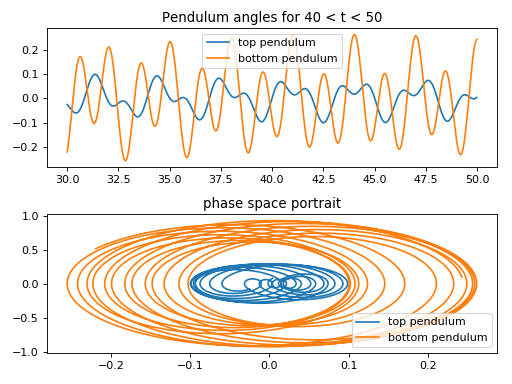

In [33]:
start, stop = start_stop_indices(t_pts, 30, 50)


fig = plt.figure()

ax1 = fig.add_subplot(2,1,1)
ax1.plot(t_pts[start:stop], p1[start:stop], label=('top pendulum'))
ax1.plot(t_pts[start:stop], p2[start:stop], label = ('bottom pendulum'))
ax1.legend()
ax1.set_title('Pendulum angles for 40 < t < 50')

ax2 = fig.add_subplot(2,1,2)
ax2.plot(p1[start:stop], pdot1[start:stop],  label=('top pendulum'))
ax2.plot(p2[start:stop], pdot2[start:stop], label = ('bottom pendulum'))
ax2.legend()
ax2.set_title('phase space portrait')

fig.tight_layout()
fig.show()

<big>
    
   Looks interesting! But is it chaotic? It seems like it may have periodic behavior. Let's try it again for larger initial angles, so that the small angle approximation doesn't apply. 

In [34]:
bphi1_0 = 2.0
bphi2_0 = -1.0
bphidot1_0 = 0.0
bphidot2_0 = 0.0

bmy_pen = DoublePen(m_1, m_2, l_1, l_2)

bp1, bp2, bpdot1, bpdot2 = bmy_pen.solve_ode(t_pts, bphi1_0, bphi2_0, bphidot1_0, bphidot2_0)

<IPython.core.display.Javascript object>


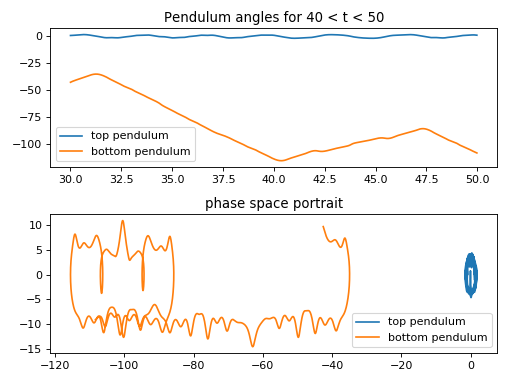

In [35]:
start, stop = start_stop_indices(t_pts, 30, 50)


fig = plt.figure()

ax1 = fig.add_subplot(2,1,1)
ax1.plot(t_pts[start:stop], bp1[start:stop], label=('top pendulum'))
ax1.plot(t_pts[start:stop], bp2[start:stop], label = ('bottom pendulum'))
ax1.legend()
ax1.set_title('Pendulum angles for 40 < t < 50')

ax2 = fig.add_subplot(2,1,2)
ax2.plot(bp1[start:stop], bpdot1[start:stop],  label=('top pendulum'))
ax2.plot(bp2[start:stop], bpdot2[start:stop], label = ('bottom pendulum'))
ax2.legend()
ax2.set_title('phase space portrait')

fig.tight_layout()
fig.show()

<big> 
    That's more like it. But how can I prove to you that this is chaos? Chaotic systems should exhibit "extreme sensitivity to initial conditions". So, let me set up two separate double pendulums, identical except for a small diference in initial conditions, and see how the differ over time.

In [38]:
# first initial conditions

cphi1_0 = 2.0
cphi2_0 = 0.0
cphidot1_0 = 0.0
cphidot2_0 = 0.0

#second initial conditions
dphi1_0 = 2.05
dphi2_0 = 0.0
dphidot1_0 = 0.0
dphidot2_0 = 0.0

pen1 = DoublePen(m_1, m_2, l_1, l_2)
pen2 = DoublePen(m_1, m_2, l_1, l_2)

cp1, cp2, cpdot1, cpdot2 = pen1.solve_ode(t_pts, cphi1_0, cphi2_0, cphidot1_0, cphidot2_0)
dp1, dp2, dpdot1, dpdot2 = pen2.solve_ode(t_pts, dphi1_0, dphi2_0, dphidot1_0, dphidot2_0)

<IPython.core.display.Javascript object>


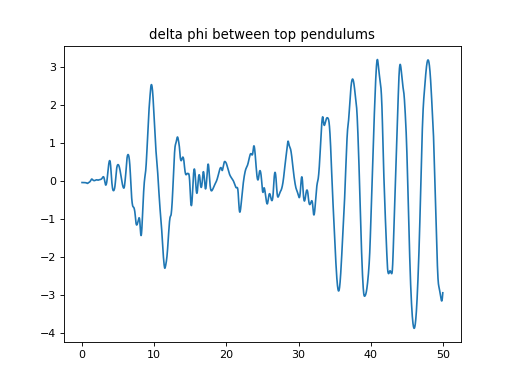

Text(0.5, 1.0, 'delta phi between top pendulums')

In [40]:
del_phi = cp1 - dp1 #the difference between the angles of the top pendulums. If there is chaos, this should never approach
                    #zero, and never settle down to a stable value. We should see it go crazy.
    
fig = plt.figure()

ax1 = fig.add_subplot(1,1,1)
ax1.plot(t_pts, del_phi)
ax1.set_title('delta phi between top pendulums')

<big><big><big> 
    I'd say that's chaotic. <br>
    FIN